In [1]:
import graphviz

from micrograd.core import Value

In [2]:
def build_graph(root: Value):
    """Build a graph with GraphViz"""
    visited = set()    
    _get_value_str = lambda v: f'{v.name} | data={v.data:0.3f} | grad={v.grad:0.3f}'

    def _expand_value(value):
        """Expand children"""
        if value in visited:
            return
        visited.add(value)
        
        if value.operator:
            # connect operator node
            operator_id = f'{id(value)}_{value.operator}'
            graph.node(operator_id, label=value.operator)
            graph.edge(operator_id, str(id(value)))
            # connect children
            for child in value.children:
                child_id = str(id(child))
                graph.node(child_id, label=_get_value_str(child), shape='record')  # child nodes
                graph.edge(child_id, operator_id)
                _expand_value(child)
            
    # process
    graph = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    graph.node(str(id(root)), _get_value_str(root), shape='record')
    _expand_value(root)
    return graph

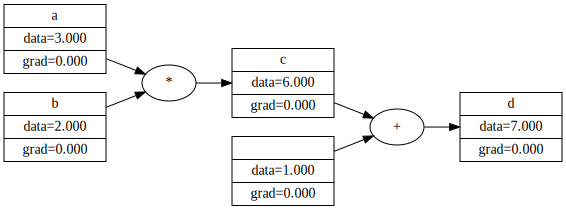

In [3]:
a = Value(3, name='a')
b = Value(2, name='b')
c = a * b
d = c + 1
c.name = 'c'
d.name = 'd'

build_graph(d)

In [4]:
def test_deriv():
    # manual deriv
    a = Value(3, name='a')
    b = Value(2, name='b')
    c = a * b
    d = c + 1
    c.name = 'c'
    d.name = 'd'
    L1 = d.data
    
    h = 0.001  # step
    a = Value(3 + h, name='a')  # adding step to a
    b = Value(2, name='b')
    c = a * b
    d = c + 1
    c.name = 'c'
    d.name = 'd'
    L2 = d.data
    
    print('Approximate derivative dL/da:', (L2-L1) / h)
    
    # numerical deriv
    d.zero_grad()
    d.backward()
    
    print('Numerical derivative dL/da:', a.grad)

test_deriv()

Approximate derivative dL/da: 1.9999999999997797
Numerical derivative dL/da: 2.0


In [5]:
a = Value(3, name='a')
b = Value(-2, name='b')
c = a * b; c.name = 'c'
d = c + 1; d.name = 'd'
e = d * b ; e.name = 'e'
e.backward()

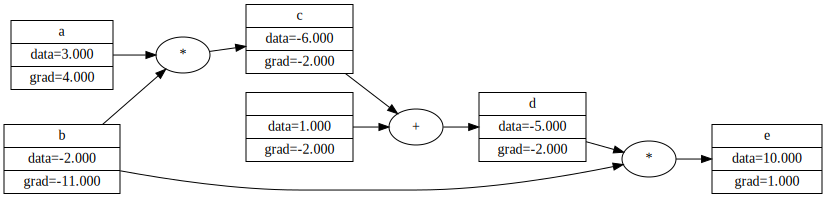

In [6]:
build_graph(e)

original data on e: 10
modified data on e: 11.424383999999998


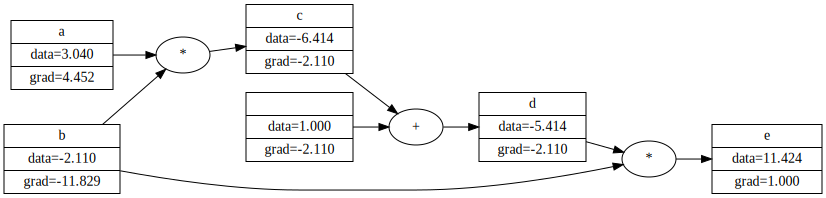

In [7]:
print('original data on e:', e.data)

# weight update
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad

# "forward pass"
c = a * b; c.name = 'c'
d = c + 1; d.name = 'd'
e = d * b ; e.name = 'e'

e.zero_grad()
e.backward()
print('modified data on e:', e.data)
build_graph(e)

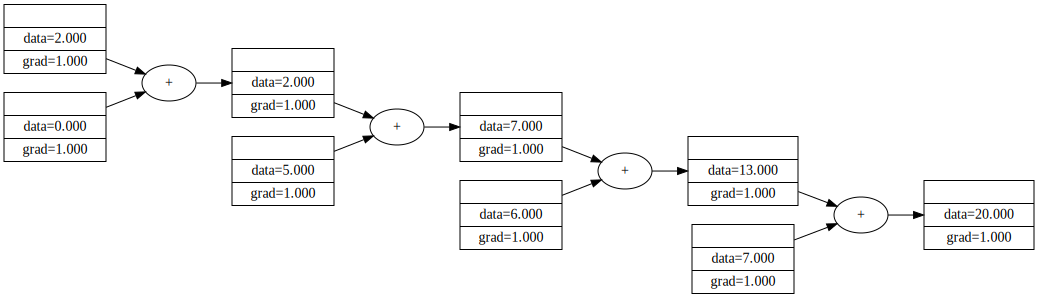

In [8]:
z = sum([Value(2), 5, 6, 7])
z.zero_grad()
z.backward()
build_graph(z)

In [9]:
import random

class Neuron:
    """
    Neuron.
    """
    
    def __init__(self, n_inputs: int, activation: str = 'tanh'):
        self.weights = [Value(random.uniform(-1, 1), name=f'w_{i}') for i in range(n_inputs)]
        self.bias = Value(random.uniform(-1, 1), 'b')
        self.activation = activation
        
    def __call__(self, x: list):
        if len(x) != len(self.weights):
            raise ValueError('Input should have the same size of weights')
        z = sum([w * i for w, i in zip(self.weights, x)]) + self.bias
        if self.activation == 'relu':
            out = z.relu()
        elif self.activation == 'tanh':
            out = z.tanh()
        else:
            raise ValueError(f'Wrong activation type: {self.activation}')
        return out
    
    def parameters(self):
        return self.weights + [self.bias]

class Layer:
    """
    Fully connected layer of neurons.
    """
    
    def __init__(self, n_inputs: int, n_outputs: int):
        self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        p = []
        for n in self.neurons:
            p.extend(n.parameters())
        return p
    
class MLP:
    """
    Multilayer perceptron.
    """
    
    def __init__(self, n_inputs: int, layer_sizes: list):
        self.sizes = [n_inputs] + layer_sizes
        self.layers = [Layer(_i, _o) for _i, _o in zip(self.sizes, self.sizes[1:])]
                       
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        p = []
        for l in self.layers:
            p.extend(l.parameters())
        return p

In [10]:
n = Neuron(2)
o = n([Value(x_i, name=f'x_{i}')
       for i, x_i
       in enumerate([1, 3])])
o

Value(data=-0.468)

In [11]:
l = Layer(2, 3)  # a layer with 3 neurons of input size 2
o = l([Value(x_i, name=f'x_{i}')
       for i, x_i
       in enumerate([1, 3])])
o

[Value(data=-0.900), Value(data=0.019), Value(data=-0.844)]

In [12]:
m = MLP(3, [4, 4, 1])  # an MLP with 3 and 2 neurons. input size 2
o = m([Value(x_i, name=f'x_{i}')
       for i, x_i
       in enumerate([1, 2, 3])])
o

Value(data=0.875)

In [13]:
print(len(m.parameters()))

41


In [23]:
xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, 1],
    # [1, 1, -1]
]
# ys = [1, -1, -1, 1]
ys = [1, -1, -1]


# predictions
y_pred = [m(x) for x in xs]
y_pred

[Value(data=0.957), Value(data=-0.971), Value(data=-0.909)]

In [24]:
# model
m = MLP(3, [4, 4, 1])  # an MLP with 3 and 2 neurons. input size 2

# sgd
epochs = 100000
lr = 0.0003
for epoch in range(epochs):
    # forward
    ys_pred = [m(x) for x in xs]
    L = sum((y - yp)**2 for y, yp in zip(ys, ys_pred))  # L2
    if epoch % 2000 == 0:
        print(f'epoch: {epoch}, loss: {L.data}')
        
    # backward
    L.zero_grad()
    L.backward()
    
    # update
    for p in m.parameters():
        p.data += -1 * lr * p.grad
    
print([m(x) for x in xs])
print(ys)

epoch: 0, loss: 2.6265650324836383
epoch: 2000, loss: 2.889310257501296
epoch: 4000, loss: 3.2281484405073364
epoch: 6000, loss: 3.4647161136271714
epoch: 8000, loss: 3.601785079433385
epoch: 10000, loss: 3.682139979451235
epoch: 12000, loss: 3.732167749159361
epoch: 14000, loss: 3.7654148968952983
epoch: 16000, loss: 3.7888391444961775
epoch: 18000, loss: 3.806170588792027
epoch: 20000, loss: 3.8195172733779104
epoch: 22000, loss: 3.830134438635119
epoch: 24000, loss: 3.838806313323391
epoch: 26000, loss: 3.846044270975346
epoch: 28000, loss: 3.8521945161309397
epoch: 30000, loss: 3.857499232654309
epoch: 32000, loss: 3.862132742718625
epoch: 34000, loss: 3.8662236903183276
epoch: 36000, loss: 3.8698691092774173
epoch: 38000, loss: 3.8731436138695368
epoch: 40000, loss: 3.8761055652704104
epoch: 42000, loss: 3.878801309194269
epoch: 44000, loss: 3.881268151471763
epoch: 46000, loss: 3.8835364884843098
epoch: 48000, loss: 3.88563135961151
epoch: 50000, loss: 3.887573596756145
epoch: 52